In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import multiprocessing as mp
from typing import List, Optional
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from xgboost import XGBRegressor
from sklearn.model_selection import ParameterGrid as PG

In [2]:
def ntest_split_data_by_submarket(data, ntest):
    train_data = pd.DataFrame()
    test_data = pd.DataFrame()
    submarkets = data['research_submkt_id'].unique()

    for submarket in submarkets:
        submarket_data = data[data['research_submkt_id'] == submarket]
        train_submarket = submarket_data.iloc[:-ntest]
        test_submarket = submarket_data.iloc[-ntest:]
        train_data = pd.concat([train_data, train_submarket])
        test_data = pd.concat([test_data, test_submarket])

    return train_data, test_data


def smape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2

    return np.mean(numerator / denominator) * 100


def all_get_submkt_forecast(df, num_lags, ntest, feature_subset):
    df_new = df[['date', 'research_submkt_id', 'real_hedonic_rent_submarket']]
    df_new['date'] = pd.to_datetime(df_new['date'])
    df['date'] = pd.to_datetime(df['date'])

    if num_lags is None:
        num_lags = 36
    
    num_lags = 36  
    for lag in range(1, num_lags+1):
        df_new['rent_{}months_ago'.format(lag)] = df_new.groupby('research_submkt_id')['real_hedonic_rent_submarket'].shift(lag)
    df_new = df_new.dropna()
    df_new = df_new.sort_values(['date', 'research_submkt_id']).reset_index(drop=True)
    
    df_sel = df[['date', 'research_submkt_id']+feature_subset]
    df_new = df_new.merge(df_sel, on=['date', 'research_submkt_id'], how='left')

    X = df_new.iloc[:, [0, 1] + list(range(3, len(df_new.columns)))]
    Y = df_new.iloc[:, :3]

    Y_train, Y_test = ntest_split_data_by_submarket(Y, ntest)
    y_train = Y_train.iloc[:, -1]
    y_test = Y_test.iloc[:, -1]
    X_train, X_test = ntest_split_data_by_submarket(X, ntest)
    x_train = X_train.iloc[:, 2:]
    x_test = X_test.iloc[:, 2:]

    param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.001]
    }

    model = XGBRegressor()
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
    grid_search.fit(x_train, y_train)

    # Get the best parameters and best score
    best_params = grid_search.best_params_
    best_score = -grid_search.best_score_
    print("Best Parameters:", best_params)
    print("Best Score (RMSE):", best_score)
    

    best_model = XGBRegressor(**best_params)
    best_model.fit(x_train, y_train)

    y_pred = best_model.predict(x_test)

    Y_test_pred = Y_test.copy()
    Y_test_pred['y_pred'] = y_pred

    whole_smape = smape(y_test, y_pred)

    smape_dic = {}
    submkt_id = df_new['research_submkt_id'].unique().tolist()
    for submkt in submkt_id:
        y_submkt_test = Y_test_pred[Y_test_pred['research_submkt_id'] == submkt]['real_hedonic_rent_submarket']
        y_submkt_pred = Y_test_pred[Y_test_pred['research_submkt_id'] == submkt]['y_pred']
        submkt_smape = smape(y_submkt_test, y_submkt_pred)
        smape_dic[submkt] = submkt_smape

    # print(f"{submkt} - SMAPE: {smape_value:.2f}%")

    return {
        'Y_test_pred': Y_test_pred,
        'smape_dic': smape_dic,
        'whole_smape': whole_smape,
        'best_params': best_params
    }



def get_feature_subsets(
        feature_space,
        subset_size,
        include_features: Optional[List[str]] = None,
        intersect_size: int = 1,
):
    subset_size = max(1, subset_size)
    subset_size = min(subset_size, len(feature_space))
    subset_li = []

    for subset in itertools.combinations(feature_space, subset_size):
        subset = list(subset)
        if include_features is not None:
            intersect_size = min(subset_size, intersect_size)
        subset_li.append(subset)

    return subset_li



def run_attribute_permutation_pipeline(df, num_lags, ntest, feature_space, subset_size, intersect_size):

    feature_subsets = get_feature_subsets(
        feature_space,
        subset_size=subset_size,
        include_features=None,
        intersect_size=intersect_size
    )
    
    param_vals = {
        "feature_subsets": feature_subsets
    }
    param_grid = list(PG(param_vals))
    num_params = len(param_grid)
    
    results = {}
    pool = mp.Pool(processes=mp.cpu_count())

    for idx, params in enumerate(param_grid):
        print(f"training model {idx}/{num_params - 1}: {params}")
        result = pool.apply_async(all_get_submkt_forecast, kwds={
            "df": df,
            "num_lags": num_lags,
            "ntest": ntest,
            "feature_subset": params['feature_subsets'],
            # Pass other required parameters here
        })
        params = str(params)
        results[params] = result

    pool.close()
    pool.join()

    df_parts = []

    # Iterate over each key-value pair in 'results'
    for key, value in results.items():
        dic = value.get()
        y_pred_df = dic['Y_test_pred']
        smape_dic = dic['smape_dic']
        best_params = dic['best_params']
        data = []

        for index, row in y_pred_df.iterrows():
            research_submkt_id = row['research_submkt_id']
            date = row['date']
            real_hedonic_rent_submarket = row['real_hedonic_rent_submarket']
            y_pred = row['y_pred']

            smape = smape_dic.get(research_submkt_id)

            submarket_best_params = best_params

            submarket_info = {
                'research_submkt_id': research_submkt_id,
                'date': date,
                'real_hedonic_rent_submarket': real_hedonic_rent_submarket,
                'y_pred': y_pred,
                'smape': smape,
                'best_hyperparams': submarket_best_params,
                'best_attributes': key  
            }

            data.append(submarket_info)

        df_part = pd.DataFrame(data)

        df_parts.append(df_part)

    df = pd.concat(df_parts, ignore_index=True)
    min_smape_index = df.groupby('research_submkt_id')['smape'].idxmin()
    smallest_smape_df = df.loc[min_smape_index, ['research_submkt_id', 'smape', 'best_hyperparams', 'best_attributes']]


    return df, smallest_smape_df


def plot_submkt_forecast(df, smallest_smape_df):
    for index, row in smallest_smape_df.iterrows():
        research_submkt_id = row['research_submkt_id']
        group = row['best_attributes']
        smape = row['smape']

        # Filter 'df' based on 'research_submkt_id' and 'group'-best_attributes
        submarket_df = df[(df['research_submkt_id'] == research_submkt_id) & (df['best_attributes'] == group)]

        # Extract the test and predicted values
        dates = submarket_df['date']
        y_test = submarket_df['real_hedonic_rent_submarket']
        y_pred = submarket_df['y_pred']

        # Plot the test and predicted values
        plt.plot(dates, y_test, label='Test')
        plt.plot(dates, y_pred, label='Predicted')
        plt.xlabel('Date')
        plt.ylabel('Rent')
        plt.title(f'Submarket {research_submkt_id} - Group {group} (SMAPE: {smape:.2f})')  # Include SMAPE in the plot title
        plt.legend()

        # Add SMAPE as a text annotation
        plt.annotate(f'SMAPE: {smape:.2f}', xy=(0.02, 0.92), xycoords='axes fraction')

        plt.show()


In [3]:
df = pd.read_csv('/mnt/container1/zqiao_Workspace/link-research/ad-hoc/zq-sandbox/submkt_data/submkt_train_data/pho_submkt_train_test_data.csv')
num_lags = 36
ntest = 24
subset_size = 2
intersect_size = 1
feature_space = [
                 "real_market_level_rent",
                 "gdp_histfc",
                 "nominal_retail_sales_histfc",]
                 #"employment_histfc",
                 #"real_ecommerce",
                 #"spread_3m10y",
                 #"real_retail_sales_ex_gas",
                 #"imports_us",
                 #"ecomm^2_pop",
                 #"weighted_pop_estimate_cryr",
                 #"weighted_hh_estimate_cryr"]


In [4]:
df, smallest_smape_df = run_attribute_permutation_pipeline(df, num_lags, ntest, feature_space, subset_size, intersect_size)

/tmp/ipykernel_98712/1551431245.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['date'] = pd.to_datetime(df_new['date'])
/tmp/ipykernel_98712/1551431245.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['rent_{}months_ago'.format(lag)] = df_new.groupby('research_submkt_id')['real_hedonic_rent_submarket'].shift(lag)
/tmp/ipykernel_98712/1551431245.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

/tmp/ipykernel_98712/1551431245.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['rent_{}months_ago'.format(lag)] = df_new.groupby('research_submkt_id')['real_hedonic_rent_submarket'].shift(lag)
/tmp/ipykernel_98712/1551431245.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['rent_{}months_ago'.format(lag)] = df_new.groupby('research_submkt_id')['real_hedonic_rent_submarket'].shift(lag)
/tmp/ipykernel_98712/1551431245.py:35: SettingWithCopyWarning: 
A value is trying to be set on a cop

/tmp/ipykernel_98712/1551431245.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['rent_{}months_ago'.format(lag)] = df_new.groupby('research_submkt_id')['real_hedonic_rent_submarket'].shift(lag)
/tmp/ipykernel_98712/1551431245.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['rent_{}months_ago'.format(lag)] = df_new.groupby('research_submkt_id')['real_hedonic_rent_submarket'].shift(lag)
/tmp/ipykernel_98712/1551431245.py:35: SettingWithCopyWarning: 
A value is trying to be set on a cop

/tmp/ipykernel_98712/1551431245.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['rent_{}months_ago'.format(lag)] = df_new.groupby('research_submkt_id')['real_hedonic_rent_submarket'].shift(lag)
/tmp/ipykernel_98712/1551431245.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['rent_{}months_ago'.format(lag)] = df_new.groupby('research_submkt_id')['real_hedonic_rent_submarket'].shift(lag)
/tmp/ipykernel_98712/1551431245.py:35: SettingWithCopyWarning: 
A value is trying to be set on a cop

/tmp/ipykernel_98712/1551431245.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['rent_{}months_ago'.format(lag)] = df_new.groupby('research_submkt_id')['real_hedonic_rent_submarket'].shift(lag)
/tmp/ipykernel_98712/1551431245.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['rent_{}months_ago'.format(lag)] = df_new.groupby('research_submkt_id')['real_hedonic_rent_submarket'].shift(lag)
/tmp/ipykernel_98712/1551431245.py:35: SettingWithCopyWarning: 
A value is trying to be set on a cop

/tmp/ipykernel_98712/1551431245.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['rent_{}months_ago'.format(lag)] = df_new.groupby('research_submkt_id')['real_hedonic_rent_submarket'].shift(lag)
/tmp/ipykernel_98712/1551431245.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['rent_{}months_ago'.format(lag)] = df_new.groupby('research_submkt_id')['real_hedonic_rent_submarket'].shift(lag)
/tmp/ipykernel_98712/1551431245.py:35: SettingWithCopyWarning: 
A value is trying to be set on a cop

training model 0/2: {'feature_subsets': ['real_market_level_rent', 'gdp_histfc']}
training model 1/2: {'feature_subsets': ['real_market_level_rent', 'nominal_retail_sales_histfc']}
training model 2/2: {'feature_subsets': ['gdp_histfc', 'nominal_retail_sales_histfc']}
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best Score (RMSE): 0.02437710433770794
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best Score (RMSE): 0.025264684711194307
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best Score (RMSE): 0.02542336731313652


In [50]:
df.to_csv('/mnt/container1/zqiao_Workspace/link-research/ad-hoc/zq-sandbox/submkt_forecsat_model/seperate_pipeline_final/xgboost_result_flake/xgboost_result1_pred_pho')

In [41]:
df_parts = []

    # Iterate over each key-value pair in 'results'
for key, value in results.items():
    dic = value.get()
    y_pred_df = dic['Y_test_pred']
    smape_dic = dic['smape_dic']
    best_params = dic['best_params']
    data = []

    for index, row in y_pred_df.iterrows():
        research_submkt_id = row['research_submkt_id']
        date = row['date']
        real_hedonic_rent_submarket = row['real_hedonic_rent_submarket']
        y_pred = row['y_pred']

        smape = smape_dic.get(research_submkt_id)

        submarket_best_params = best_params

        submarket_info = {
            'research_submkt_id': research_submkt_id,
            'date': date,
            'real_hedonic_rent_submarket': real_hedonic_rent_submarket,
            'y_pred': y_pred,
            'smape': smape,
            'best_hyperparams': submarket_best_params,
            'best_attributes': key  
        }

        data.append(submarket_info)

    df_part = pd.DataFrame(data)

    df_parts.append(df_part)

df = pd.concat(df_parts, ignore_index=True)
min_smape_index = df.groupby('research_submkt_id')['smape'].idxmin()
smallest_smape_df = df.loc[min_smape_index, ['research_submkt_id', 'smape', 'best_hyperparams', 'best_attributes']]




In [42]:
df

,research_submkt_id,date,real_hedonic_rent_submarket,y_pred,smape,best_hyperparams,best_attributes
0,PHO037,2021-08-01,6.865879,6.844805,0.953087,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...","{'feature_subsets': ['real_market_level_rent',..."
1,PHO037,2021-09-01,6.895755,6.859122,0.953087,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...","{'feature_subsets': ['real_market_level_rent',..."
2,PHO037,2021-10-01,6.935858,6.889123,0.953087,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...","{'feature_subsets': ['real_market_level_rent',..."
3,PHO037,2021-11-01,6.996811,6.892659,0.953087,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...","{'feature_subsets': ['real_market_level_rent',..."
4,PHO037,2021-12-01,7.021086,6.957020,0.953087,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...","{'feature_subsets': ['real_market_level_rent',..."
...,...,...,...,...,...,...,...
2011,PHO055,2023-03-01,6.429850,6.447610,1.404741,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...","{'feature_subsets': ['gdp_histfc', 'nominal_re..."
2012,PHO055,2023-04-01,6.404212,6.470181,1.404741,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...","{'feature_subsets': ['gdp_histfc', 'nominal_re..."
2013,PHO055,2023-05-01,6.434404,6.422547,1.404741,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...","{'feature_subsets': ['gdp_histfc', 'nominal_re..."
2014,PHO055,2023-06-01,6.443685,6.462801,1.404741,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...","{'feature_subsets': ['gdp_histfc', 'nominal_re..."


In [46]:
df

,research_submkt_id,date,real_hedonic_rent_submarket,y_pred,smape,best_hyperparams,best_attributes
0,PHO037,2021-08-01,6.865879,6.844805,0.953087,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...","{'feature_subsets': ['real_market_level_rent',..."
1,PHO037,2021-09-01,6.895755,6.859122,0.953087,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...","{'feature_subsets': ['real_market_level_rent',..."
2,PHO037,2021-10-01,6.935858,6.889123,0.953087,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...","{'feature_subsets': ['real_market_level_rent',..."
3,PHO037,2021-11-01,6.996811,6.892659,0.953087,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...","{'feature_subsets': ['real_market_level_rent',..."
4,PHO037,2021-12-01,7.021086,6.957020,0.953087,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...","{'feature_subsets': ['real_market_level_rent',..."
...,...,...,...,...,...,...,...
2011,PHO055,2023-03-01,6.429850,6.447610,1.404741,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...","{'feature_subsets': ['gdp_histfc', 'nominal_re..."
2012,PHO055,2023-04-01,6.404212,6.470181,1.404741,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...","{'feature_subsets': ['gdp_histfc', 'nominal_re..."
2013,PHO055,2023-05-01,6.434404,6.422547,1.404741,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...","{'feature_subsets': ['gdp_histfc', 'nominal_re..."
2014,PHO055,2023-06-01,6.443685,6.462801,1.404741,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...","{'feature_subsets': ['gdp_histfc', 'nominal_re..."


In [51]:
df.to_csv('/mnt/container1/zqiao_Workspace/link-research/ad-hoc/zq-sandbox/submkt_forecsat_model/seperate_pipeline_final/xgboost_result_flake/xgboost_result1_pred_pho.csv')

smallest_smape_df.to_csv('/mnt/container1/zqiao_Workspace/link-research/ad-hoc/zq-sandbox/submkt_forecsat_model/seperate_pipeline_final/xgboost_result_flake/xgboost_result1_pho.csv')

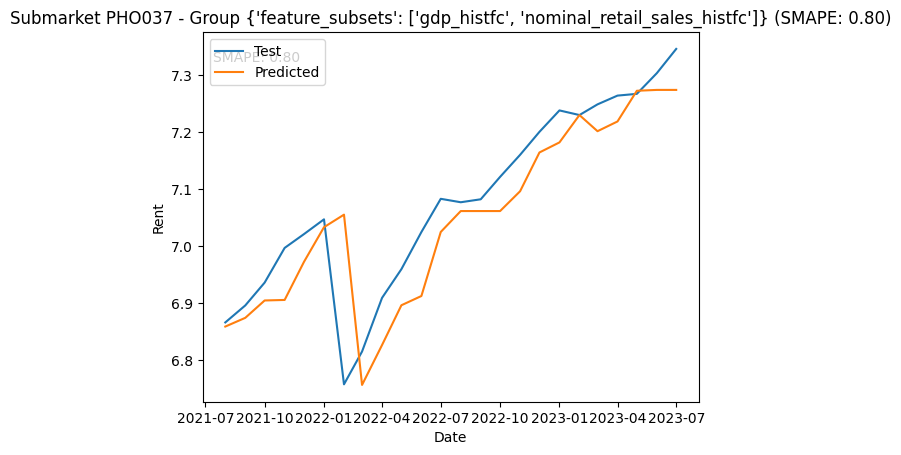

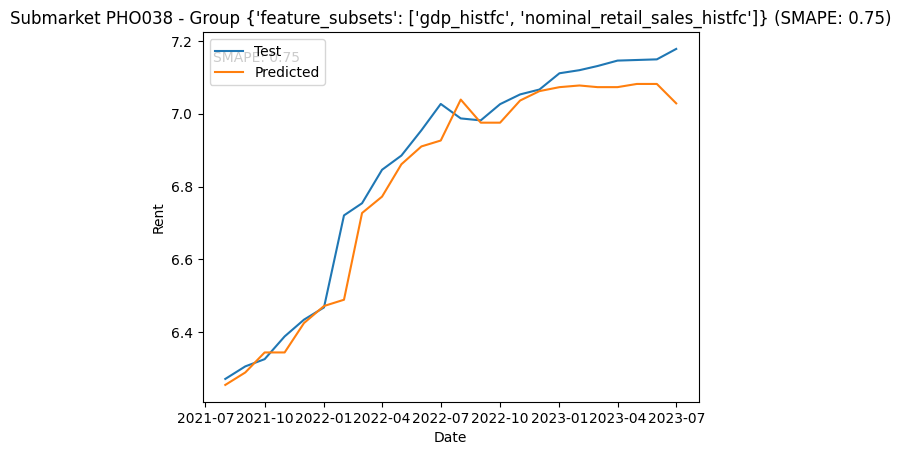

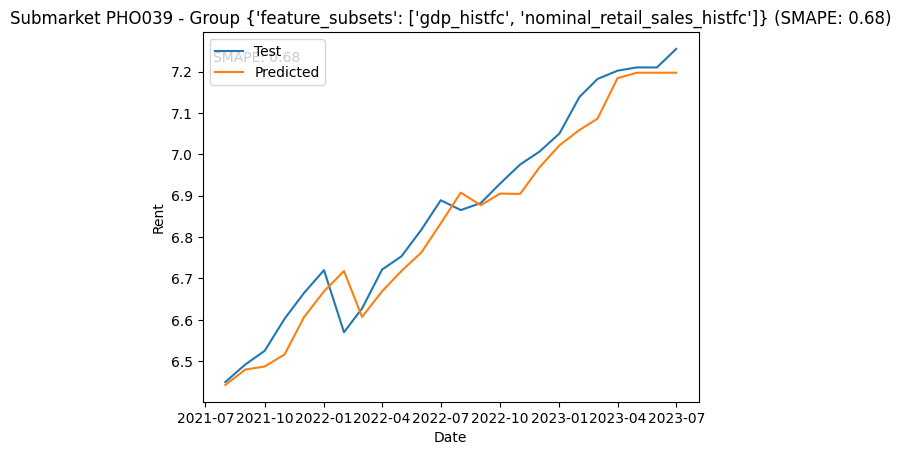

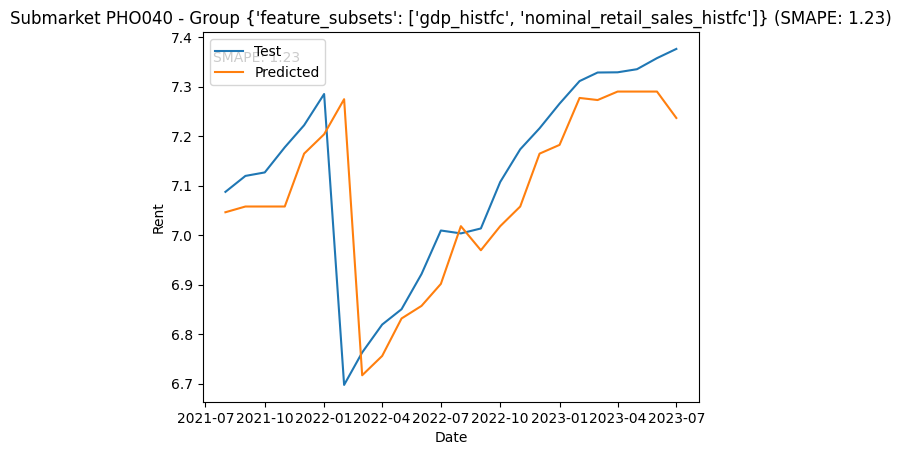

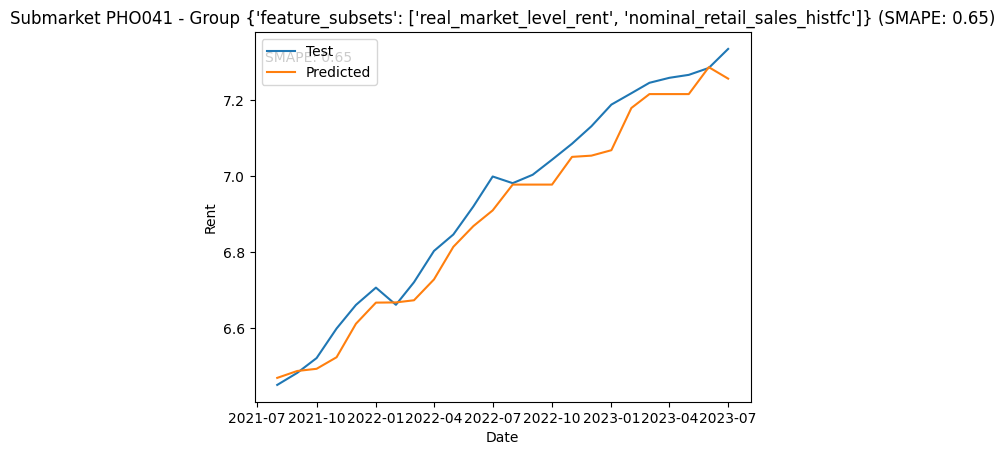

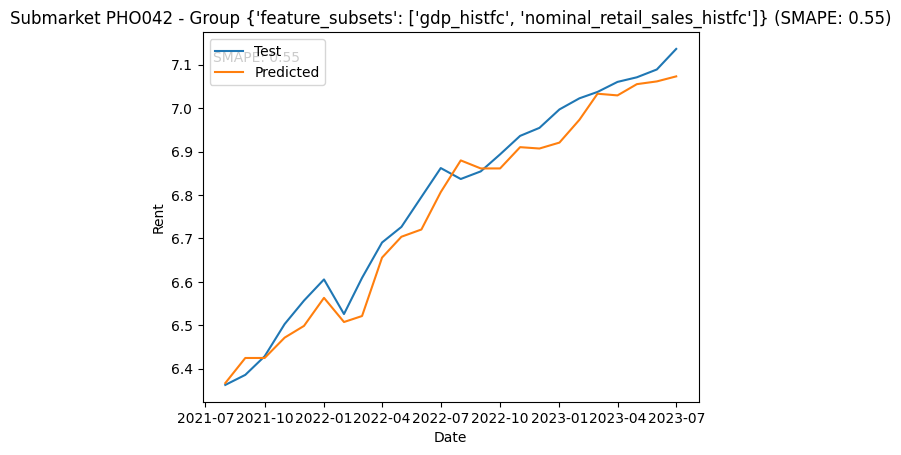

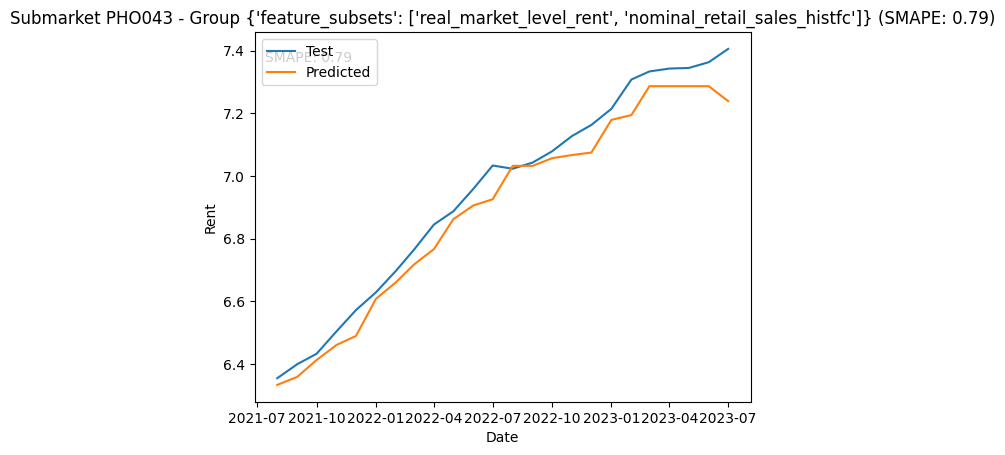

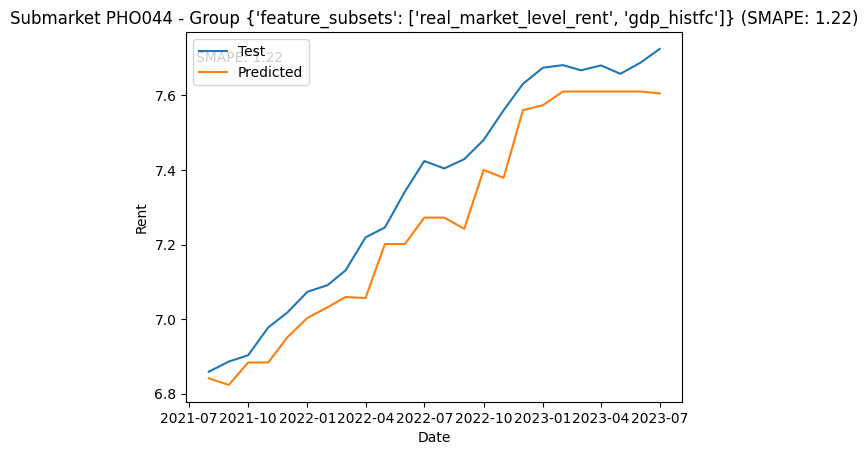

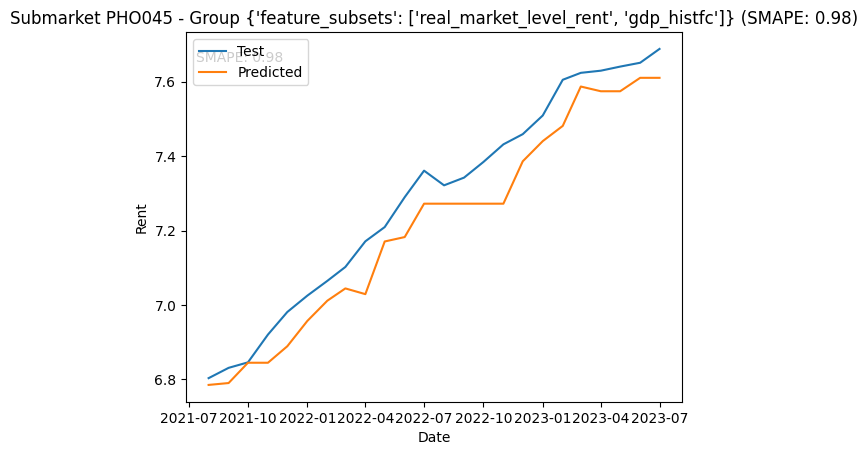

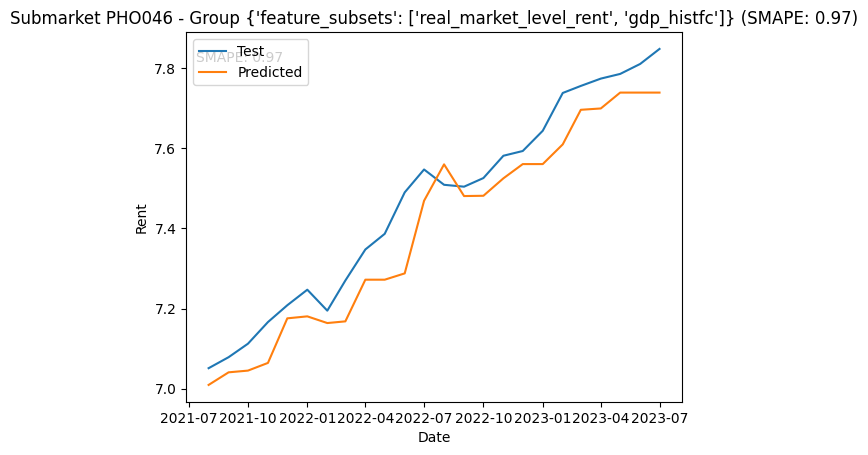

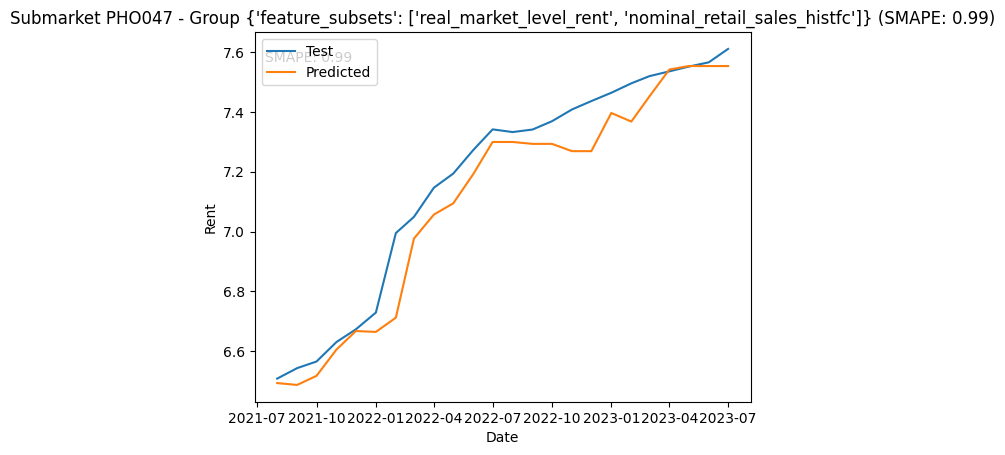

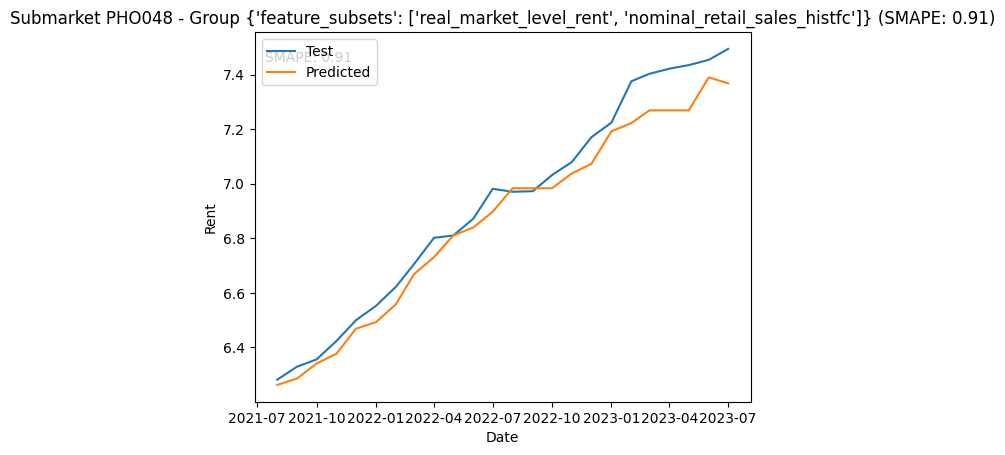

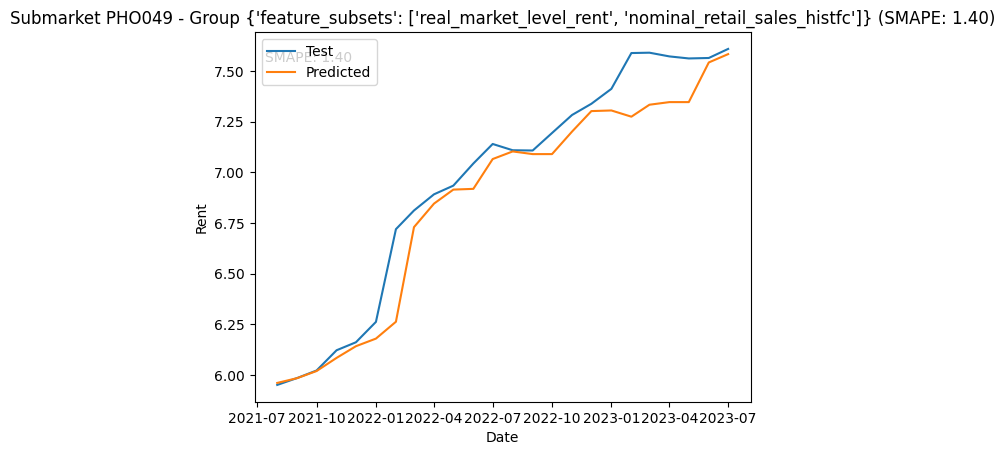

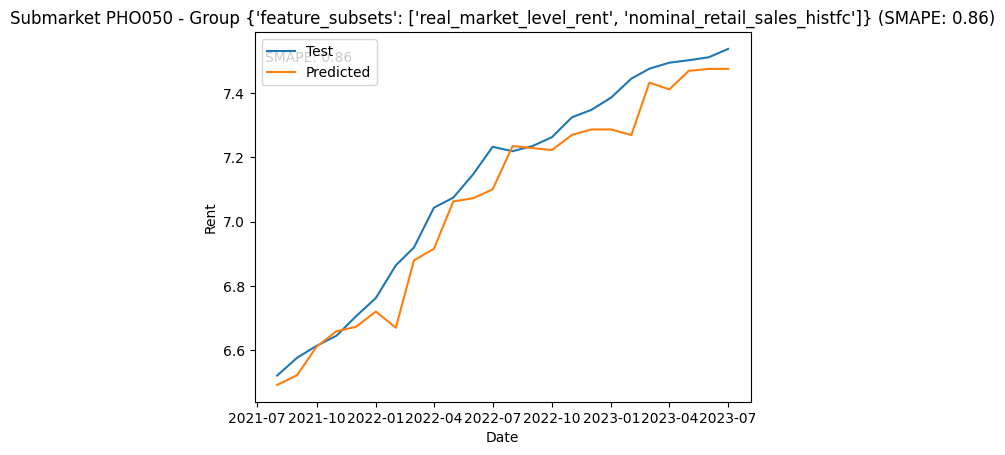

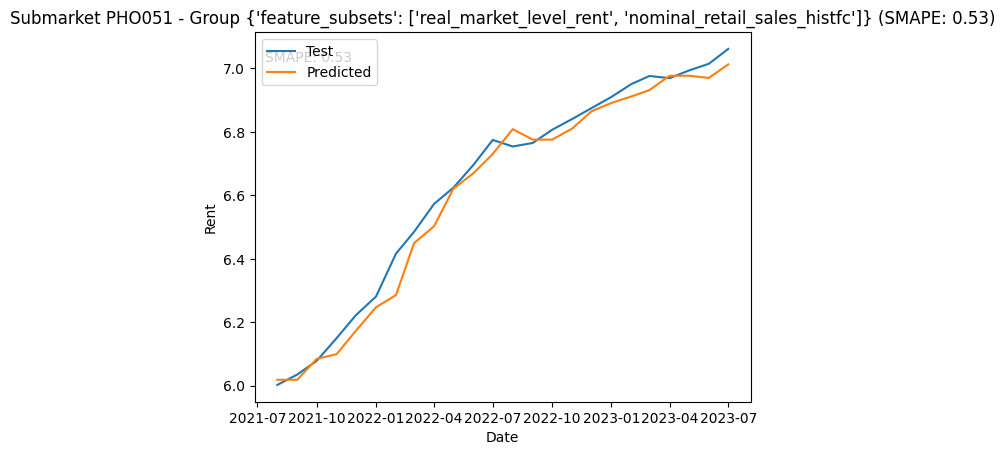

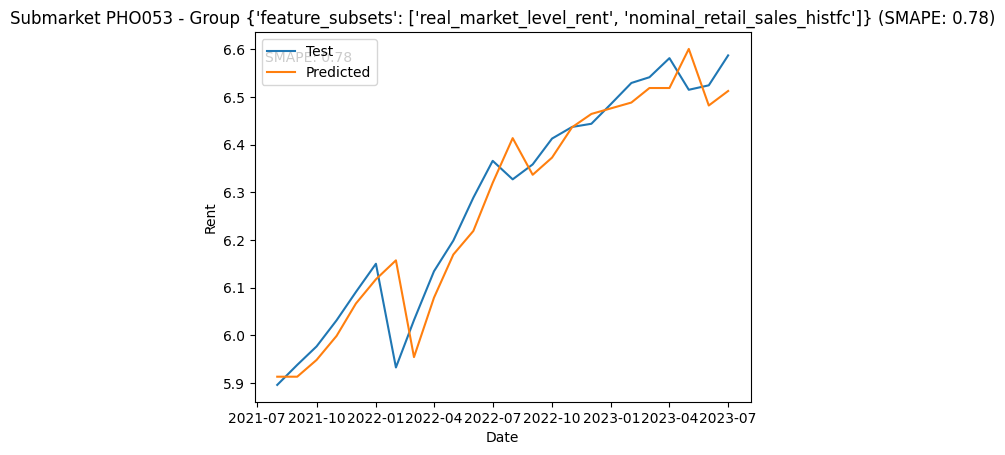

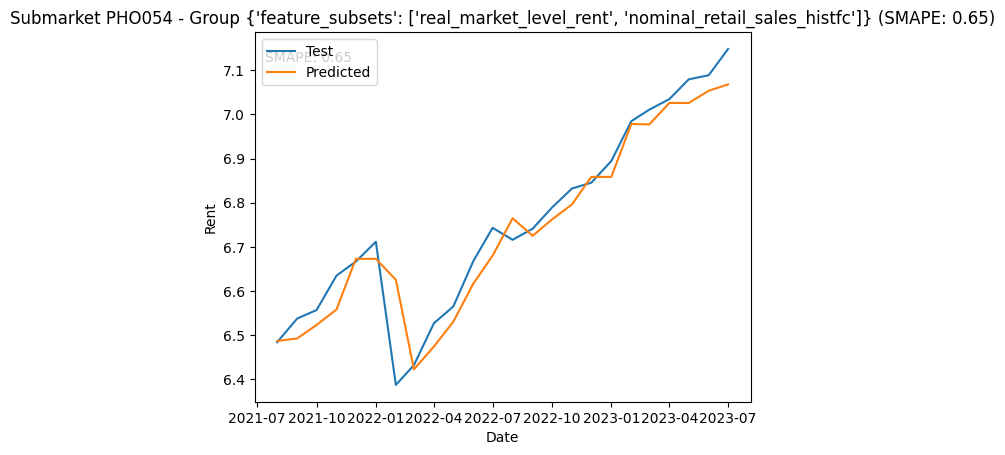

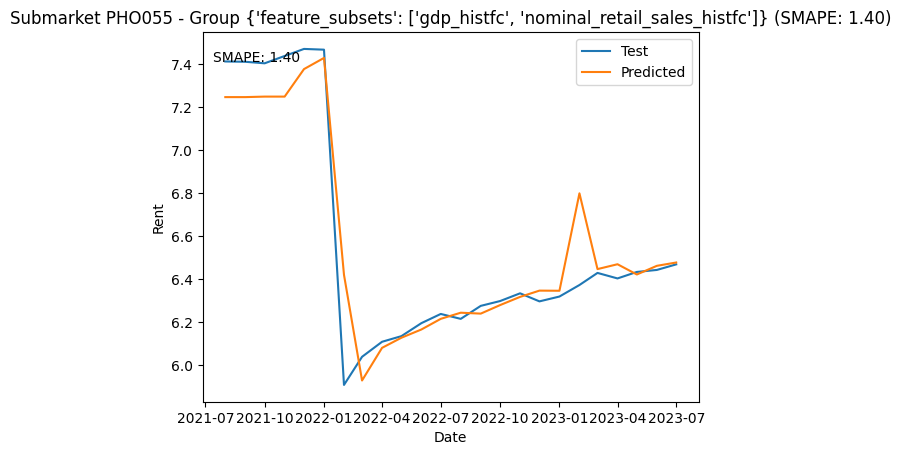

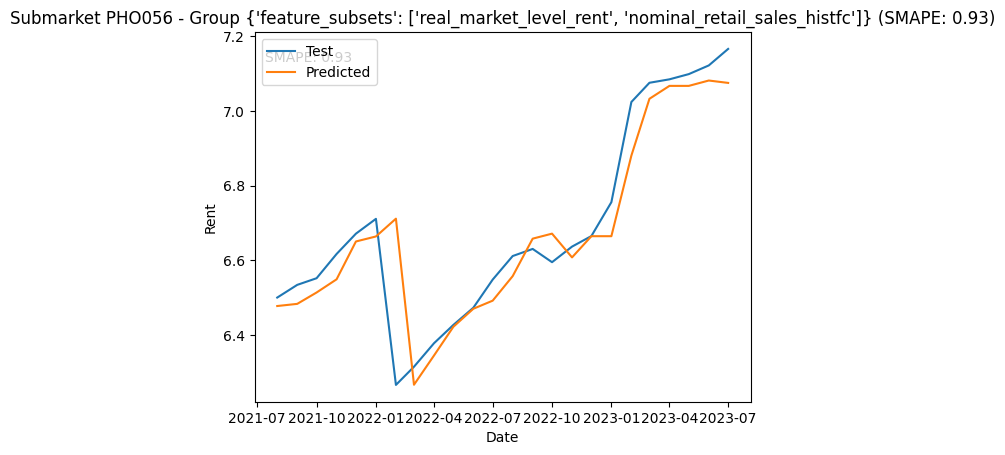

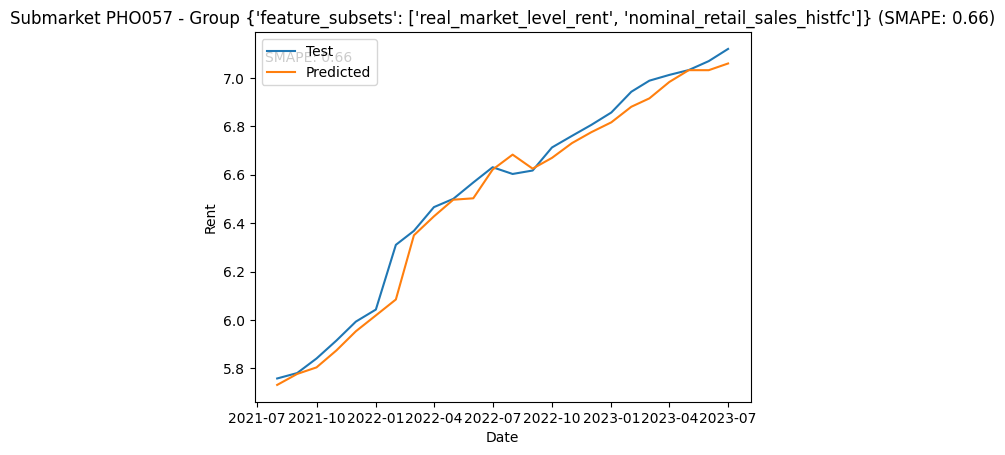

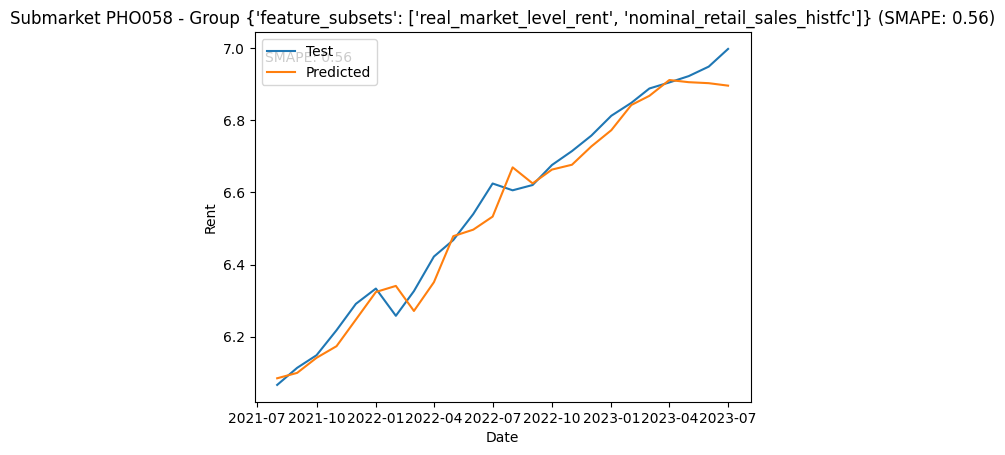

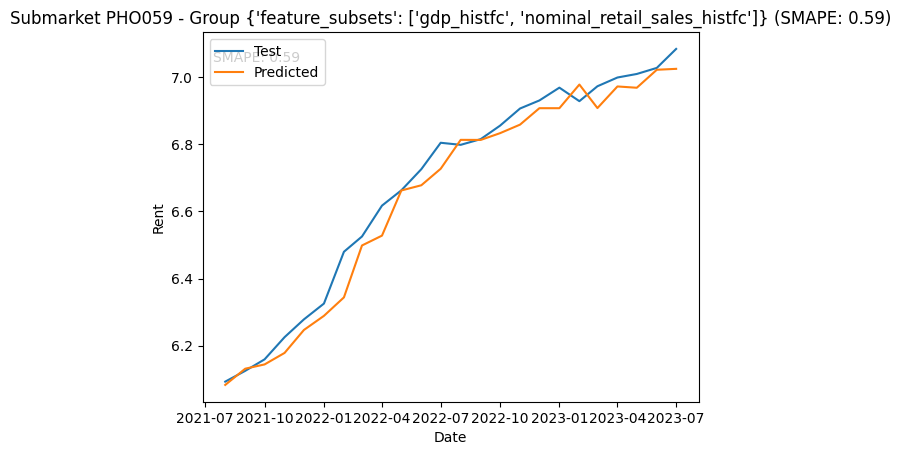

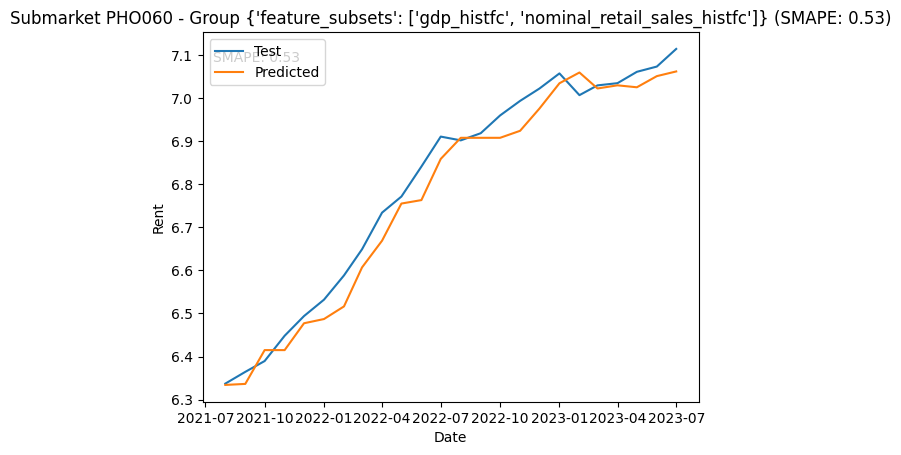

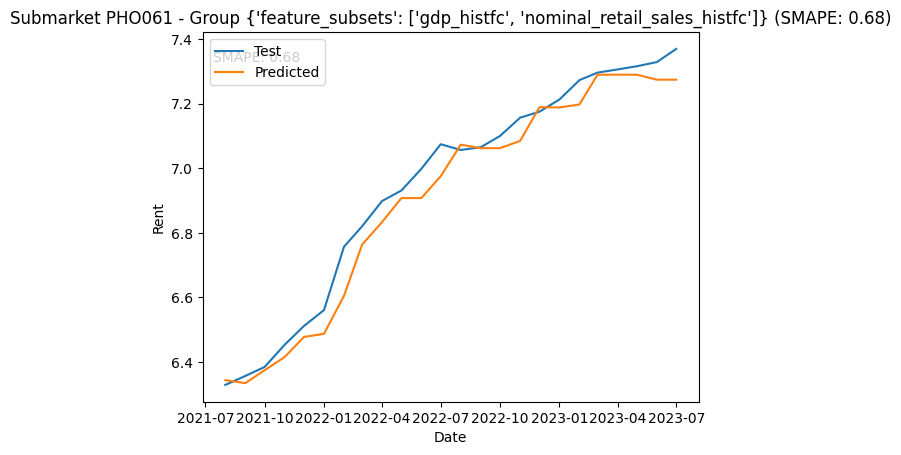

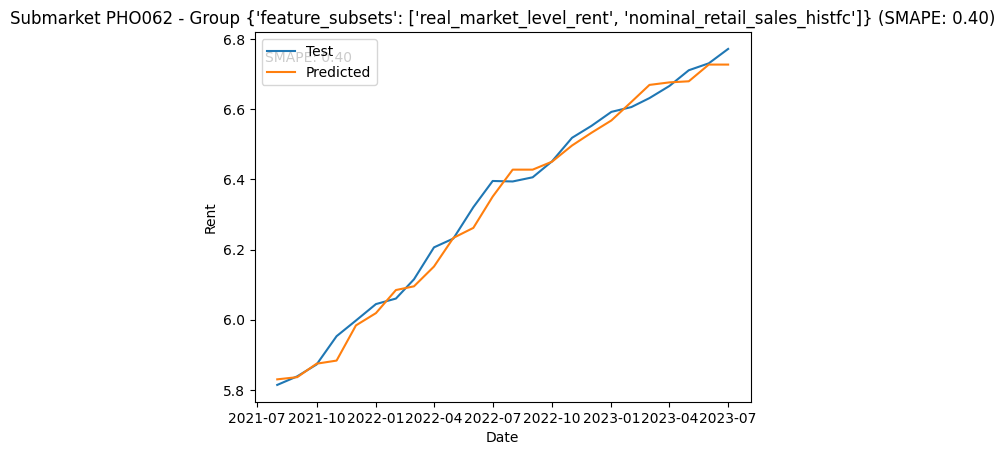

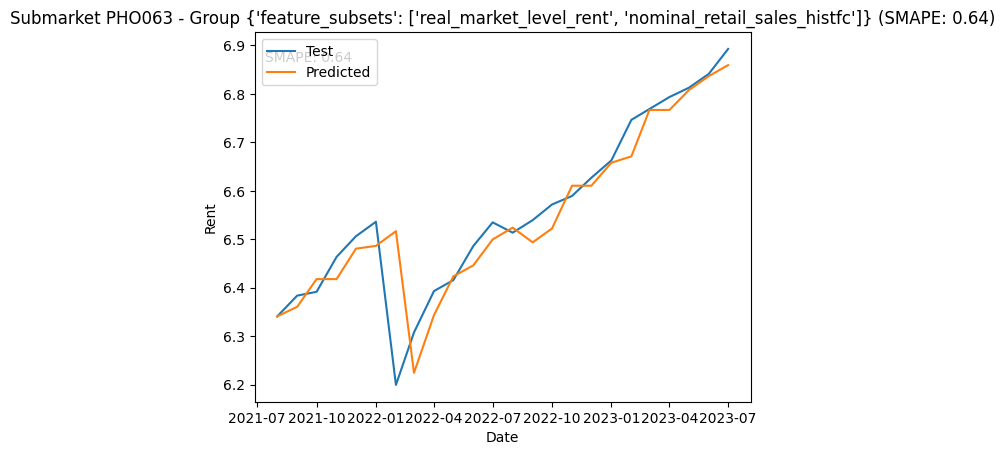

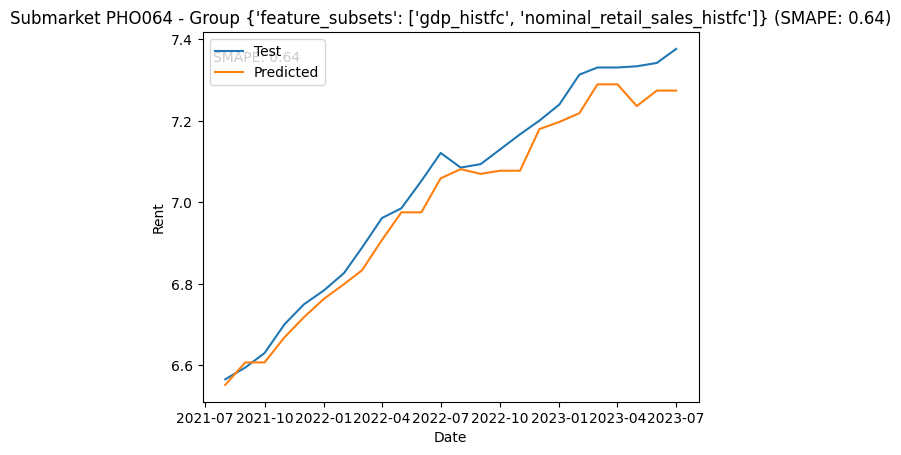

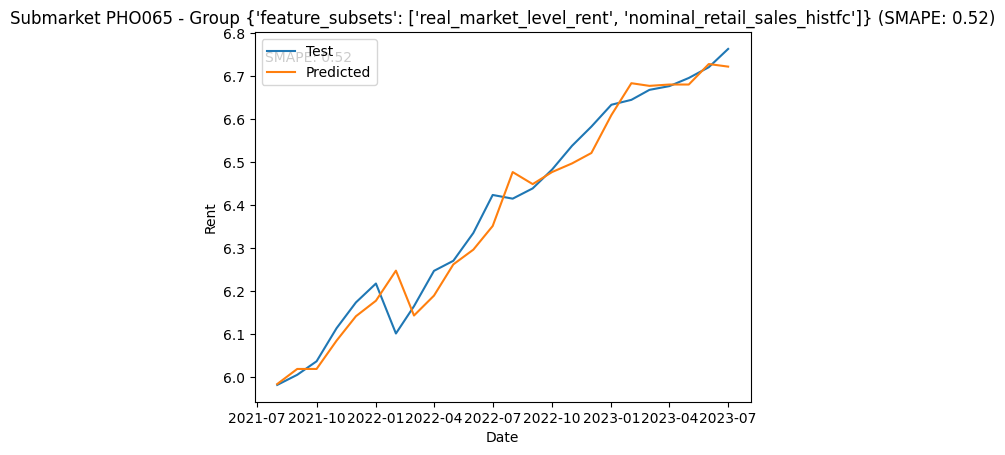

In [44]:
for index, row in smallest_smape_df.iterrows():
    research_submkt_id = row['research_submkt_id']
    group = row['best_attributes']
    smape = row['smape']

    # Filter 'df' based on 'research_submkt_id' and 'group'-best_attributes
    submarket_df = df[(df['research_submkt_id'] == research_submkt_id) & (df['best_attributes'] == group)]

    # Extract the test and predicted values
    dates = submarket_df['date']
    y_test = submarket_df['real_hedonic_rent_submarket']
    y_pred = submarket_df['y_pred']

    # Plot the test and predicted values
    plt.plot(dates, y_test, label='Test')
    plt.plot(dates, y_pred, label='Predicted')
    plt.xlabel('Date')
    plt.ylabel('Rent')
    plt.title(f'Submarket {research_submkt_id} - Group {group} (SMAPE: {smape:.2f})')  # Include SMAPE in the plot title
    plt.legend()

    # Add SMAPE as a text annotation
    plt.annotate(f'SMAPE: {smape:.2f}', xy=(0.02, 0.92), xycoords='axes fraction')

    plt.show()


In [ ]:
def get_final_results_xgboost_pipeline():
    df_parts = []

    # Iterate over each key-value pair in 'results'
    for key, value in results.items():
        dic = value.get()
        y_pred_df = dic['Y_test_pred']
        smape_dic = dic['smape_dic']
        best_params = dic['best_params']
        data = []

        for index, row in y_pred_df.iterrows():
            research_submkt_id = row['research_submkt_id']
            date = row['date']
            real_hedonic_rent_submarket = row['real_hedonic_rent_submarket']
            y_pred = row['y_pred']

            smape = smape_dic.get(research_submkt_id)

            submarket_best_params = best_params

            submarket_info = {
                'research_submkt_id': research_submkt_id,
                'date': date,
                'real_hedonic_rent_submarket': real_hedonic_rent_submarket,
                'y_pred': y_pred,
                'smape': smape,
                'best_hyperparams': submarket_best_params,
                'best_attributes': key  
            }

            data.append(submarket_info)

        df_part = pd.DataFrame(data)

        df_parts.append(df_part)

    df = pd.concat(df_parts, ignore_index=True)
    min_smape_index = df.groupby('research_submkt_id')['smape'].idxmin()
    smallest_smape_df = df.loc[min_smape_index, ['research_submkt_id', 'smape', 'best_hyperparams', 'best_attributes']]


    return df, smallest_smape_df


